In [158]:
!pip install pyspark


In [159]:
# Import các thư viện cần thiết
from pyspark.sql import SparkSession
# import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
# import pandas as pd
import os
# import math


In [160]:
from pyspark import SparkContext, SparkConf


In [161]:
from pyspark.sql.functions import col
from pyspark.sql.types import *

In [162]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [163]:
MAIN_PATH = "/content/drive/MyDrive/Year4/BIGDATA/final/main"
DATA_RAW_PATH = os.path.join(MAIN_PATH,"Live_raw.csv")
DATA_TRANS_PATH = os.path.join(MAIN_PATH,"Live.csv")

In [164]:
spark = SparkSession.builder \
    .appName("YourAppName") \
    .master("local[*]").getOrCreate()

In [165]:
df = spark.read.option("header", True).csv(DATA_TRANS_PATH)

In [166]:
df.show(10)

+-----------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+------------------+-------------------+
|status_type|       num_reactions|        num_comments|          num_shares|           num_likes|         num_loves|            num_wows|           num_hahas|          num_sads|         num_angrys|
+-----------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+------------------+-------------------+
|          3| 0.11231422505307856|0.024392567889471178| 0.07651869158878505| 0.09171974522292993|0.1400304414003044| 0.01079136690647482|0.006369426751592357|0.0196078431372549|                0.0|
|          1| 0.03184713375796178|                 0.0|                 0.0| 0.03184713375796178|               0.0|                 0.0|                 0.0|               0.0|                0.0|
|         

In [167]:
fileRDD = spark.sparkContext.textFile(os.path.join(DATA_TRANS_PATH))


In [168]:
# Skip the header and split the lines into lists of strings
dataRDD = fileRDD.filter(lambda line: 'status_type' not in line).map(lambda line: line.split(','))

# Convert the strings to floats
floatDataRDD = dataRDD.map(lambda values: [float(value) for value in values])


In [169]:
data_check = floatDataRDD.filter(lambda value : len(value)!= 10 )

In [170]:
data_check.collect()

[]

In [171]:
floatDataRDD.count()

7050

In [172]:

# Collect the result as a list of lists
floatDataRDD.collect()

[[3.0,
  0.11231422505307856,
  0.024392567889471178,
  0.07651869158878505,
  0.09171974522292993,
  0.1400304414003044,
  0.01079136690647482,
  0.006369426751592357,
  0.0196078431372549,
  0.0],
 [1.0,
  0.03184713375796178,
  0.0,
  0.0,
  0.03184713375796178,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [3.0,
  0.048195329087048835,
  0.01124344926155312,
  0.01664719626168224,
  0.04331210191082802,
  0.0319634703196347,
  0.0035971223021582736,
  0.006369426751592357,
  0.0,
  0.0],
 [1.0,
  0.02356687898089172,
  0.0,
  0.0,
  0.02356687898089172,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [1.0,
  0.04522292993630573,
  0.0,
  0.0,
  0.04331210191082802,
  0.0136986301369863,
  0.0,
  0.0,
  0.0,
  0.0],
 [1.0,
  0.04607218683651804,
  0.00028585040495474035,
  0.0,
  0.04479830148619957,
  0.0076103500761035,
  0.0035971223021582736,
  0.0,
  0.0,
  0.0],
 [3.0,
  0.10679405520169852,
  0.029252024773701764,
  0.02102803738317757,
  0.08874734607218683,
  0.106544901065449,
  0.03597122302

In [173]:
# from pyspark.mllib.linalg import Vectors
# from pyspark.mllib.linalg.distributed import RowMatrix

In [174]:
sc = SparkContext.getOrCreate()


In [175]:
def euclid(x, y):
  if x is None or y is None:
        raise ValueError("Input points cannot be None.")
  if len(x) != len(y):
    raise ValueError("Points must have the same dimensionality.")
  distance_squared = sum((xi - yi)**2 for xi, yi in zip(x, y))**0.5
  return distance_squared

In [176]:

def find_cluster(x, centers):
    try :
      center = centers[0]
      dmin = float('inf')
      for c in centers:
          d = euclid(x, c)
          if d < dmin:
              dmin = d
              center = c
      return center
    except Exception as e :
      print(f"Error: {e}")


In [177]:
def map_clusters(rdd, centers):
    return rdd.map(lambda x: (x, find_cluster(x, centers)))

In [178]:

def cal_distance_nearest_center(x, centers):
    try :
      distance = float('inf')
      for c in centers:
          d = euclid(x, c)
          if d < distance:
              distance = d
      return distance
    except Exception as e :
      print(f"Error: {e}")

In [179]:
def find_centers(clusters, old_centers):
    new_centers = []
    for c in old_centers:
        cluster_rdd = clusters.filter(lambda x: euclid(x[1], c) == 0).map(lambda x: x[0])

        if cluster_rdd.isEmpty():
            distance_rdd = clusters.map(lambda x: (x[0], cal_distance_nearest_center(x[1], new_centers)))
            new_centers.append(distance_rdd.max(lambda x: x[1])[0])
        else:
            # new_centers.append(cluster_rdd.sum()/cluster_rdd.count())
            new_centers.append([sum(x) / len(x) for x in zip(*cluster_rdd.collect())])


    return new_centers


In [180]:
def kmeans(rdd, k, seed):
    cost = 10000000
    result_centers = None
    for i in range(5):
        seed += 1
        centers = rdd.takeSample(False, k, seed=seed)
        while True:
            clusters = map_clusters(rdd, centers).cache()

            new_centers = find_centers(clusters, centers)

            # Check for convergence
            should_stop = all(euclid(c, new_c) < 0.0001 for c, new_c in zip(centers, new_centers))

            if should_stop:
                break

            centers = new_centers

        c = cal_cost(clusters)
        if c < cost:
            cost = c
            result_centers = centers

        clusters.unpersist()
    return cost, result_centers

In [181]:
def cal_cost(clusters):
    total_distance = clusters.map(lambda x: euclid(x[0], x[1])).sum()
    count = clusters.count()
    return total_distance / count if count else float('inf')

In [182]:
# seed = 0
# costs = []
# for k in range(2, 10):
#     costs.append(kmeans(floatDataRDD, k, seed)[0])
#     print(costs[-1])

In [183]:
# plt.plot(range(2, 10), costs)

In [184]:
# plt.plot(range(2, 10), costs)

In [185]:
# %%time%%
results = kmeans(floatDataRDD, 5, 0)

In [186]:
results[1]

[[0.0,
  0.07858659387321813,
  0.0002714822629067508,
  0.0012841195668298465,
  0.07847538166009511,
  0.000459036988717354,
  0.000685166152792052,
  0.00020220402386007482,
  0.0,
  0.0],
 [3.0,
  0.06017134321949837,
  0.03060877318248011,
  0.033785031713235485,
  0.051595631457435835,
  0.05409478570375851,
  0.008806322551213455,
  0.01105234719106643,
  0.008115328393568204,
  0.008195815020593218],
 [2.0,
  0.09315999185644079,
  0.0017264581307471897,
  0.0007473434899500688,
  0.09246895268010366,
  0.002376931256646029,
  0.004217995466640383,
  0.0006980193700375186,
  0.007574536663980658,
  0.0007954043305346884],
 [1.0,
  0.4105095541401281,
  0.002831934620881734,
  0.005053412562904377,
  0.4088345173934348,
  0.0069810326659641726,
  0.010601134477033758,
  0.0018985791278784908,
  0.0010369532428355956,
  0.00015508684863523573],
 [1.0,
  0.019524166354439806,
  0.0006564283645807023,
  0.0005262735935495668,
  0.019049737729486673,
  0.00195593458083388,
  0.00204

In [187]:
clusters = map_clusters(floatDataRDD, results[1])

In [188]:
clusters.collect()

[([3.0,
   0.11231422505307856,
   0.024392567889471178,
   0.07651869158878505,
   0.09171974522292993,
   0.1400304414003044,
   0.01079136690647482,
   0.006369426751592357,
   0.0196078431372549,
   0.0],
  [3.0,
   0.06017134321949837,
   0.03060877318248011,
   0.033785031713235485,
   0.051595631457435835,
   0.05409478570375851,
   0.008806322551213455,
   0.01105234719106643,
   0.008115328393568204,
   0.008195815020593218]),
 ([1.0,
   0.03184713375796178,
   0.0,
   0.0,
   0.03184713375796178,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0],
  [1.0,
   0.019524166354439806,
   0.0006564283645807023,
   0.0005262735935495668,
   0.019049737729486673,
   0.00195593458083388,
   0.0020480674284102285,
   0.0011802173098538823,
   0.002883506343713954,
   0.0015417457305502839]),
 ([3.0,
   0.048195329087048835,
   0.01124344926155312,
   0.01664719626168224,
   0.04331210191082802,
   0.0319634703196347,
   0.0035971223021582736,
   0.006369426751592357,
   0.0,
   0.0],
  [3.0,
   0

In [189]:
# def visualize_clusters(clusters):
#     # Extract data points and cluster centers
#     data_points = [x[0] for x in clusters]
#     cluster_centers = [x[1] for x in clusters]

#     # Get the number of dimensions in the data points
#     num_dimensions = len(data_points[0])

#     # Plot data points
#     for i in range(num_dimensions):
#         dimension_values = [point[i] for point in data_points]
#         plt.scatter(range(1, len(data_points) + 1), dimension_values, label=f'Dimension {i+1}', alpha=0.5)

#     # Plot cluster centers
#     for i in range(num_dimensions):
#         center_values = [center[i] for center in cluster_centers]
#         plt.scatter(range(1, len(cluster_centers) + 1), center_values, c='red', marker='X', s=100, label=f'Cluster Center Dimension {i+1}')

#     # Connect data points to their respective cluster centers with lines
#     for i in range(len(data_points)):
#         for j in range(num_dimensions):
#             plt.plot([i + 1, i + 1], [data_points[i][j], cluster_centers[i][j]], 'k-', linestyle='dotted', linewidth=0.5)

#     plt.xlabel('Data Points')
#     plt.ylabel('Values')
#     plt.title('Cluster Visualization')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

In [190]:
# visualize_clusters(clusters.collect())

In [191]:
from sklearn.decomposition import PCA

In [192]:
def visualize_clusters(clusters):
    data_points = [x[0] for x in clusters]
    cluster_centers = [x[1] for x in clusters]

    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data_points)
    reduced_centers = pca.transform(cluster_centers)

    # Visualize the clusters in 2D
    plt.figure(figsize=(10,6))

    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], label='Data Points', s=2, alpha=0.7)


    # for i, center in enumerate(reduced_centers):
    #     plt.scatter(center[0], center[1], label=f'Center Point {i + 1}', s=10, marker='X')

    plt.title('Cluster Visualization (2D PCA)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()



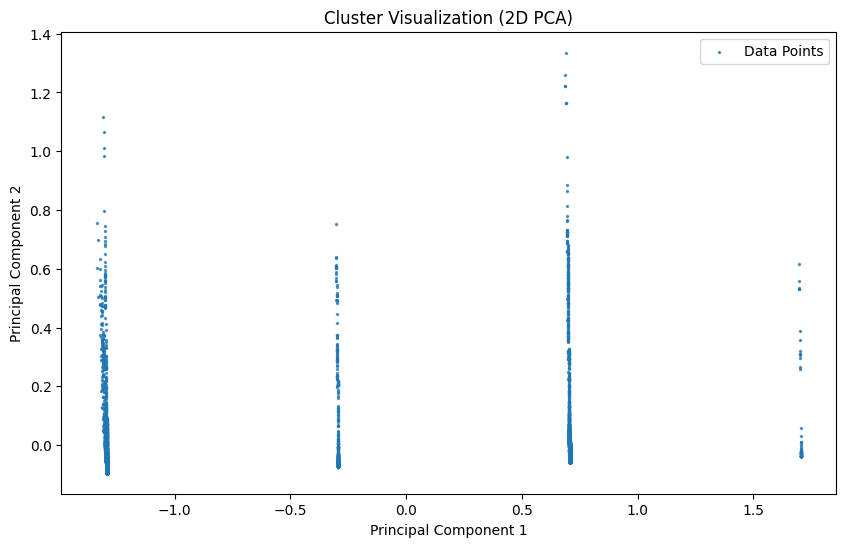

In [193]:
visualize_clusters(clusters.collect())

In [194]:
centers = [x for x in results[1]]
def assign_cluster(x):
    for i, center in enumerate(centers):
        if euclid(x[1], center) == 0:
            return x[0],i
    return x[0], None

In [195]:
assigned_rdd = clusters.map(assign_cluster)

In [196]:
assigned_rdd.collect()

[([3.0,
   0.11231422505307856,
   0.024392567889471178,
   0.07651869158878505,
   0.09171974522292993,
   0.1400304414003044,
   0.01079136690647482,
   0.006369426751592357,
   0.0196078431372549,
   0.0],
  1),
 ([1.0,
   0.03184713375796178,
   0.0,
   0.0,
   0.03184713375796178,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0],
  4),
 ([3.0,
   0.048195329087048835,
   0.01124344926155312,
   0.01664719626168224,
   0.04331210191082802,
   0.0319634703196347,
   0.0035971223021582736,
   0.006369426751592357,
   0.0,
   0.0],
  1),
 ([1.0,
   0.02356687898089172,
   0.0,
   0.0,
   0.02356687898089172,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0],
  4),
 ([1.0,
   0.04522292993630573,
   0.0,
   0.0,
   0.04331210191082802,
   0.0136986301369863,
   0.0,
   0.0,
   0.0,
   0.0],
  4),
 ([1.0,
   0.04607218683651804,
   0.00028585040495474035,
   0.0,
   0.04479830148619957,
   0.0076103500761035,
   0.0035971223021582736,
   0.0,
   0.0,
   0.0],
  4),
 ([3.0,
   0.10679405520169852,
   0.029

In [197]:
def silhouette_score(cluster_mapped):
    data_and_centers = cluster_mapped.collect()
    n = len(data_and_centers)
    total_silhouette = 0

    for i in range(n):
        data_i, center_i = data_and_centers[i]
        a_i = 0
        b_i = float('inf')

        for j in range(n):
            if i != j:
                data_j, center_j = data_and_centers[j]
                distance_ij = euclid(data_i, data_j)

                # Calculate average distance within the same cluster (a_i)
                if center_i == center_j:
                    a_i += distance_ij

                # Calculate the smallest average distance to points in different clusters (b_i)
                else:
                    b_i = min(b_i, distance_ij)

        # Calculate Silhouette Score for data point i
        a_i /= n - 1 if n > 1 else 1
        silhouette_i = (b_i - a_i) / max(a_i, b_i) if max(a_i, b_i) > 0 else 0
        total_silhouette += silhouette_i

    # Calculate average Silhouette Score
    silhouette_score_value = total_silhouette / n
    return silhouette_score_value

In [198]:
# def silhouette_score(cluster_mapped):
#     n = cluster_mapped.count()
#     total_silhouette = cluster_mapped.map(lambda x: calculate_silhouette(x, cluster_mapped)).sum()

#     silhouette_score_value = total_silhouette / n
#     return silhouette_score_value

In [199]:
silhouette_score_result = silhouette_score(clusters)
print("Silhouette Score:", silhouette_score_result)

Silhouette Score: 0.9136814004176198


In [221]:
def davies_bouldin_index(cluster_mapped):
    data_and_centers = cluster_mapped.collect()
    # k = 5
    cluster_centers = cluster_mapped.map(lambda x: x[1]).collect()  # List of cluster centers
    unique_cluster_centers = list(set(tuple(center) for center in cluster_centers))


    cluster_distances = []

    for i in range(len(unique_cluster_centers)):
        max_distance = 0

        for j in range(len(unique_cluster_centers)):
            if i != j:
                centroid_distance = euclid(unique_cluster_centers[i], unique_cluster_centers[j])
                avg_within_cluster_distance = calculate_average_distance(data_and_centers, unique_cluster_centers[i])
                if avg_within_cluster_distance > 0:
                    distance_ratio = centroid_distance / avg_within_cluster_distance
                    max_distance = max(max_distance, distance_ratio)

        cluster_distances.append(max_distance)

    davies_bouldin_index_value = sum(cluster_distances) / k
    return davies_bouldin_index_value

In [226]:
def calculate_average_distance(data_and_centers, cluster_label):
    cluster_points =[]
    for point in data_and_centers :
      if euclid(point[1],cluster_label)==0:
         cluster_points.append(point)
    # print(len(cluster_points))
    avg_distance = sum(euclid(center, data) for data, center in cluster_points) / len(cluster_points) if len(cluster_points) > 0 else 0
    return avg_distance

In [227]:
davies_bouldin_index_result = davies_bouldin_index(clusters)
print("Davies-Bouldin Index:", davies_bouldin_index_result)

Davies-Bouldin Index: 16.129589865566402


In [228]:
from sklearn.metrics import calinski_harabasz_score, homogeneity_completeness_v_measure
from sklearn.metrics.cluster import contingency_matrix

In [229]:
def calinski_harabasz_index(cluster_mapped,assigned_rdd_input):
    """
    Calculate the Calinski-Harabasz Index for k-means clustering.

    Parameters:
    - data_points: List of data points.
    - center_points: List of center points for each cluster.
    - labels: Cluster assignments for each data point.

    Returns:
    - CHI (Calinski-Harabasz Index) score.

    """
    data_and_centers = cluster_mapped.collect()
    cluster_centers = cluster_mapped.map(lambda x: x[1]).collect()  # List of cluster centers
    data_points = cluster_mapped.map(lambda x : x[0]).collect()
    center_points = list(set(tuple(center) for center in cluster_centers))
    labels = assigned_rdd_input.map(lambda x : x[1]).collect()

    return calinski_harabasz_score(data_points, labels)

In [230]:
calinski_harabasz_index_result = calinski_harabasz_index(clusters,assigned_rdd)
print("calinski_harabasz_index:", calinski_harabasz_index_result)

calinski_harabasz_index: 83930.4706013787


In [231]:
k_cluster = [3,4,5,6,7,8]
k_metric = {}

for k in k_cluster :
  print(f"Clustering with k = {k}")
  results = kmeans(floatDataRDD, k, 0)
  clusters_rs = map_clusters(floatDataRDD, results[1])
  assigned_rdd_rs = clusters_rs.map(assign_cluster)
  silhouette_score_metric = silhouette_score(clusters_rs)
  davies_bouldin_index_metric= davies_bouldin_index(clusters_rs)
  calinski_harabasz_index_metric = calinski_harabasz_index(clusters_rs,assigned_rdd_rs)
  k_metric[f"k_{k}"] = [silhouette_score_metric,davies_bouldin_index_metric,calinski_harabasz_index_metric]


Clustering with k = 3
Clustering with k = 4
Clustering with k = 5
Clustering with k = 6
Clustering with k = 7
Clustering with k = 8


In [232]:
def plot_metrics(k_metric):
    k_values = [int(k.split('_')[1]) for k in k_metric.keys()]
    silhouette_scores = [metric[0] for metric in k_metric.values()]
    davies_bouldin_scores = [metric[1] for metric in k_metric.values()]
    calinski_harabasz_scores = [metric[2] for metric in k_metric.values()]

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

    ax1.plot(k_values, silhouette_scores, marker='o', label='Silhouette Score')
    ax1.set_title('Silhouette Score for Different Values of k')
    ax1.set_ylabel('Silhouette Score')
    ax1.legend()

    ax2.plot(k_values, davies_bouldin_scores, marker='o', label='Davies-Bouldin Index')
    ax2.set_title('Davies-Bouldin Index for Different Values of k')
    ax2.set_ylabel('Davies-Bouldin Index')
    ax2.legend()

    ax3.plot(k_values, calinski_harabasz_scores, marker='o', label='Calinski-Harabasz Index')
    ax3.set_title('Calinski-Harabasz Index for Different Values of k')
    ax3.set_xlabel('Number of Clusters (k)')
    ax3.set_ylabel('Calinski-Harabasz Index')
    ax3.legend()

    plt.tight_layout()
    plt.show()

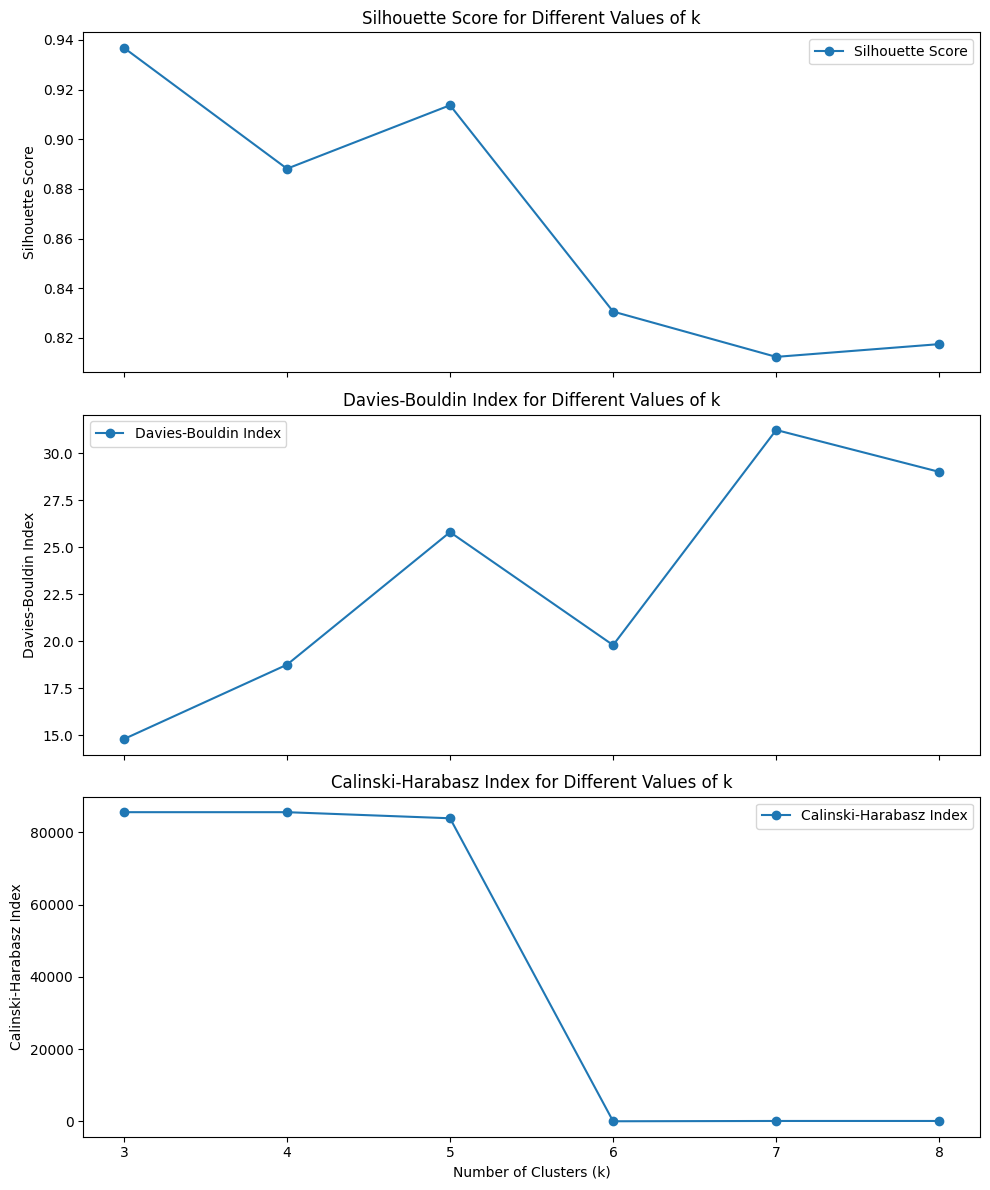

In [233]:
plot_metrics(k_metric)


In [234]:
# def cluster_purity(labels_true, labels_pred):
#     """
#     Calculate the Cluster Purity for k-means clustering.

#     Parameters:
#     - labels_true: True labels of data points.
#     - labels_pred: Predicted labels from k-means clustering.

#     Returns:
#     - Cluster Purity score.
#     """
#     cm = contingency_matrix(labels_true, labels_pred)
#     return cm.max(axis=1).sum() / cm.sum()

In [235]:
# def homogeneity_completeness(labels_true, labels_pred):
#     """
#     Calculate Homogeneity and Completeness for k-means clustering.

#     Parameters:
#     - labels_true: True labels of data points.
#     - labels_pred: Predicted labels from k-means clustering.

#     Returns:
#     - Tuple containing Homogeneity and Completeness scores.
#     """
#     h, c, _ = homogeneity_completeness_v_measure(labels_true, labels_pred)
#     return h, c

In [236]:
for i in range(4):
    print('clusters thu: ', i)
    print(assigned_rdd.filter(lambda x: x[1] == i).collect())

clusters thu:  0
[([0.0, 0.003397027600849257, 0.0004287756074321105, 0.0, 0.0031847133757961785, 0.0015220700152207, 0.0, 0.0, 0.0, 0.0], 0), ([0.0, 0.0031847133757961785, 0.0, 0.0, 0.0031847133757961785, 0.0, 0.0, 0.0, 0.0, 0.0], 0), ([0.0, 0.0070063694267515925, 4.7641734159123394e-05, 0.0002920560747663551, 0.0070063694267515925, 0.0, 0.0, 0.0, 0.0, 0.0], 0), ([0.0, 0.009766454352441613, 0.00014292520247737017, 0.0002920560747663551, 0.009766454352441613, 0.0, 0.0, 0.0, 0.0, 0.0], 0), ([0.0, 0.035881104033970275, 0.0, 0.01664719626168224, 0.03524416135881104, 0.0030441400304414, 0.0, 0.006369426751592357, 0.0, 0.0], 0), ([0.0, 0.05031847133757962, 0.0, 0.0, 0.04861995753715499, 0.0030441400304414, 0.02158273381294964, 0.0, 0.0, 0.0], 0), ([0.0, 0.009766454352441613, 0.00014292520247737017, 0.0002920560747663551, 0.009341825902335456, 0.0030441400304414, 0.0, 0.0, 0.0, 0.0], 0), ([0.0, 0.0070063694267515925, 0.00019056693663649358, 0.0011682242990654205, 0.0065817409766454355, 0.001

In [237]:
label = spark.sparkContext.broadcast(assigned_rdd.collect())

In [238]:
# in các nhãn cụm của dữ liệu ra
with open(os.path.join(MAIN_PATH,r'label.csv'), "w") as output:
     output.write('label')
     for x in label.value:
        output.write('\n'+str(x[1]))

In [239]:
schema = StructType([
    StructField("status_id", IntegerType(), nullable=True),
    StructField("status_type", StringType(), nullable=True),
    StructField("status_published", StringType(), nullable=True),
    StructField("num_reactions", IntegerType(), nullable=True),
    StructField("num_comments", IntegerType(), nullable=True),
    StructField("num_shares", IntegerType(), nullable=True),
    StructField("num_likes", IntegerType(), nullable=True),
    StructField("num_loves", IntegerType(), nullable=True),
    StructField("num_wows", IntegerType(), nullable=True),
    StructField("num_hahas", IntegerType(), nullable=True),
    StructField("num_sads", IntegerType(), nullable=True),
    StructField("num_angrys", IntegerType(), nullable=True),
    StructField("Column1", StringType(), nullable=True),
    StructField("Column2", StringType(), nullable=True),
    StructField("Column3", StringType(), nullable=True),
    StructField("Column4", StringType(), nullable=True)]
)


In [240]:
from pyspark.sql.functions import monotonically_increasing_id, row_number
from pyspark.sql.window import Window


df_root = spark.read.option("header",True).csv(DATA_RAW_PATH, schema = schema)
df_label = spark.read.option("header",True).csv(os.path.join(MAIN_PATH,"label.csv"))

df_root = df_root.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))
df_label = df_label.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))

df_label = df_label.join(df_root, on=["row_index"]).drop("row_index")

columns_to_drop = ['status_id','Column1','Column2','Column3','Column4']
newdf = df_label.drop(*columns_to_drop)

newdf.show(n=5)

+-----+-----------+-------------------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+
|label|status_type|   status_published|num_reactions|num_comments|num_shares|num_likes|num_loves|num_wows|num_hahas|num_sads|num_angrys|
+-----+-----------+-------------------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+
|    1|      video|2018-04-22 06:00:00|          529|         512|       262|      432|       92|       3|        1|       1|         0|
|    4|      photo|2018-04-21 22:45:00|          150|           0|         0|      150|        0|       0|        0|       0|         0|
|    1|      video|2018-04-21 06:17:00|          227|         236|        57|      204|       21|       1|        1|       0|         0|
|    4|      photo|2018-04-21 02:29:00|          111|           0|         0|      111|        0|       0|        0|       0|         0|
|    4|      photo|2018-04-18 03:22:00|  

In [241]:
# cluster 0
df_cluster0 = newdf.filter(newdf.label == '0')
df_cluster0.toPandas().to_csv(os.path.join(MAIN_PATH,r'cluster0.csv'), index = False, header = True)
print('So luong phan tu cua cluster 0:', df_cluster0.count())
df_cluster0.show(n = 100)

So luong phan tu cua cluster 0: 63
+-----+-----------+-------------------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+
|label|status_type|   status_published|num_reactions|num_comments|num_shares|num_likes|num_loves|num_wows|num_hahas|num_sads|num_angrys|
+-----+-----------+-------------------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+
|    0|       link|2017-12-08 02:37:00|           16|           9|         0|       15|        1|       0|        0|       0|         0|
|    0|       link|2017-05-05 23:27:00|           15|           0|         0|       15|        0|       0|        0|       0|         0|
|    0|       link|2017-04-26 00:11:00|           33|           1|         1|       33|        0|       0|        0|       0|         0|
|    0|       link|2017-02-27 10:53:00|           46|           3|         1|       46|        0|       0|        0|       0|         0|
|    0

In [242]:
# cluster 1
df_cluster1 = newdf.filter(newdf.label == '1')
df_cluster1.toPandas().to_csv(os.path.join(MAIN_PATH,r'cluster1.csv'), index = False, header = True)
print('So luong phan tu cua cluster 1:', df_cluster1.count())
df_cluster1.show(n = 100)

So luong phan tu cua cluster 1: 2334
+-----+-----------+-------------------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+
|label|status_type|   status_published|num_reactions|num_comments|num_shares|num_likes|num_loves|num_wows|num_hahas|num_sads|num_angrys|
+-----+-----------+-------------------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+
|    1|      video|2018-04-22 06:00:00|          529|         512|       262|      432|       92|       3|        1|       1|         0|
|    1|      video|2018-04-21 06:17:00|          227|         236|        57|      204|       21|       1|        1|       0|         0|
|    1|      video|2018-04-18 00:24:00|          503|         614|        72|      418|       70|      10|        2|       0|         3|
|    1|      video|2018-04-17 07:42:00|          295|         453|        53|      260|       32|       1|        1|       0|         1|
|   

In [243]:
# cluster 2
df_cluster2 = newdf.filter(newdf.label == '2')
df_cluster2.toPandas().to_csv(os.path.join(MAIN_PATH,r'cluster2.csv'), index = False, header = True)
print('So luong phan tu cua cluster 2:', df_cluster2.count())
df_cluster2.show(n = 100)

So luong phan tu cua cluster 2: 365
+-----+-----------+-------------------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+
|label|status_type|   status_published|num_reactions|num_comments|num_shares|num_likes|num_loves|num_wows|num_hahas|num_sads|num_angrys|
+-----+-----------+-------------------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+
|    2|     status|2017-09-06 06:22:00|          144|          15|         8|      140|        4|       0|        0|       0|         0|
|    2|     status|2017-08-01 00:57:00|           42|          16|         9|       41|        1|       0|        0|       0|         0|
|    2|     status|2017-07-31 09:50:00|           33|           6|         3|       31|        2|       0|        0|       0|         0|
|    2|     status|2017-03-04 09:22:00|         1043|         117|        24|      984|       58|       1|        0|       0|         0|
|    

In [244]:
# cluster 3
df_cluster3 = newdf.filter(newdf.label == '3')
df_cluster3.toPandas().to_csv(os.path.join(MAIN_PATH,r'cluster3.csv'), index = False, header = True)
print('So luong phan tu cua cluster 3:', df_cluster3.count())
df_cluster3.show(n = 100)

So luong phan tu cua cluster 3: 208
+-----+-----------+-------------------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+
|label|status_type|   status_published|num_reactions|num_comments|num_shares|num_likes|num_loves|num_wows|num_hahas|num_sads|num_angrys|
+-----+-----------+-------------------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+
|    3|      photo|2017-09-03 05:39:00|         4410|         633|       257|     4315|       73|      17|        5|       0|         0|
|    3|      photo|2017-03-11 03:13:00|         1186|          37|         1|     1161|       19|       6|        0|       0|         0|
|    3|      photo|2016-05-11 02:47:00|         1542|          18|      1260|     1520|       12|       6|        0|       4|         0|
|    3|      photo|2015-11-19 20:42:00|         1552|          23|         0|     1552|        0|       0|        0|       0|         0|
|    

In [245]:
# cluster 4
df_cluster4 = newdf.filter(newdf.label == '4')
df_cluster4.toPandas().to_csv(os.path.join(MAIN_PATH,r'cluster4.csv'), index = False, header = True)
print('So luong phan tu cua cluster 4:', df_cluster4.count())
df_cluster4.show(n = 100)

So luong phan tu cua cluster 4: 4080
+-----+-----------+-------------------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+
|label|status_type|   status_published|num_reactions|num_comments|num_shares|num_likes|num_loves|num_wows|num_hahas|num_sads|num_angrys|
+-----+-----------+-------------------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+
|    4|      photo|2018-04-21 22:45:00|          150|           0|         0|      150|        0|       0|        0|       0|         0|
|    4|      photo|2018-04-21 02:29:00|          111|           0|         0|      111|        0|       0|        0|       0|         0|
|    4|      photo|2018-04-18 03:22:00|          213|           0|         0|      204|        9|       0|        0|       0|         0|
|    4|      photo|2018-04-18 02:14:00|          217|           6|         0|      211|        5|       1|        0|       0|         0|
|   